# 2. Heart development analysis

Sim, Choon Boon, Belinda Phipson, Mark Ziemann, Haloom Rafehi, Richard J. Mills, Kevin I. Watt, Kwaku D. Abu-Bonsrah, et al. 2021. “Sex-Specific Control of Human Heart Maturation by the Progesterone Receptor.” Circulation 143 (16): 1614–28.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro

# scCODA functions
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

2023-07-04 11:23:22.771804: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 11:23:22.777507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 11:23:22.862067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 11:23:22.864731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 11:23:24.459089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

In [3]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

-------------

## Read data

In [4]:
heart_counts = pd.read_csv("data/heart_counts.tsv", sep="\t")
heart_counts

,Sample,Condition,Sex,Cardiomyocytes,Endothelial cells,Epicardial cells,Erythroid,Fibroblast,Immune cells,Neurons,Smooth muscle cells
0,a1,adult,male,1856,599,343,0,1034,449,57,22
1,a2,adult,male,564,466,493,0,1230,530,43,49
2,a3,adult,male,383,165,92,0,495,519,14,13
3,f1,fetal,male,5475,735,564,43,1029,287,109,54
4,f2,fetal,male,8580,715,425,49,755,274,130,20
5,f3,fetal,female,5140,1298,404,31,1201,196,110,136
6,y1,young,male,1073,511,613,0,1622,337,207,59
7,y2,young,female,2221,462,280,0,1688,808,71,28
8,y3,young,male,4456,550,260,0,805,731,133,49


In [5]:
heart = convert_counts_to_df(heart_counts, column_name="Celltype")
heart.head()

,Sample,Condition,Sex,Celltype
cell_1,a1,adult,male,Cardiomyocytes
cell_2,a1,adult,male,Cardiomyocytes
cell_3,a1,adult,male,Cardiomyocytes
cell_4,a1,adult,male,Cardiomyocytes
cell_5,a1,adult,male,Cardiomyocytes


-----------

## Run Scanpro

### Scanpro

In [6]:
scanpro_out = scanpro.scanpro(heart, clusters_col='Celltype', conds_col='Condition', 
                            samples_col='Sample')
scanpro_out.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_adult,mean_props_fetal,mean_props_young,f_statistics,p_values,adjusted_p_values
Celltype,,,,,,,
Cardiomyocytes,0.549464,0.273547,0.682410,0.426761,8.998537,0.000124,0.000330
Endothelial cells,0.101607,0.124538,0.102108,0.092478,0.337551,0.713515,0.713515
Epicardial cells,0.064167,0.093158,0.051415,0.075410,0.901016,0.406157,0.541542
Erythroid,0.002272,0.000000,0.004433,0.000000,197.947461,0.000000,0.000000
Fibroblast,0.182102,0.298689,0.111342,0.261924,4.602496,0.010027,0.020054
Immune cells,0.076302,0.189588,0.027546,0.108751,11.508649,0.000010,0.000040
Neurons,0.016143,0.011381,0.012643,0.026210,1.545816,0.213138,0.341021
Smooth muscle cells,0.007942,0.009099,0.008102,0.008465,0.403828,0.667759,0.713515


In [7]:
scanpro_out.results.to_csv("results/heart_scanpro_rep.tsv", sep="\t")

#### With covariate

In [8]:
scanpro_out_cofactor = scanpro.scanpro(heart, clusters_col='Celltype', conds_col='Condition', 
                            samples_col='Sample', covariates="Sex")
scanpro_out_cofactor.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_adult,mean_props_fetal,mean_props_young,f_statistics,p_values,adjusted_p_values
Celltype,,,,,,,
Cardiomyocytes,0.549464,0.273547,0.682410,0.426761,8.304494,0.000247,0.000660
Endothelial cells,0.101607,0.124538,0.102108,0.092478,0.471451,0.624096,0.624096
Epicardial cells,0.064167,0.093158,0.051415,0.075410,0.549832,0.577047,0.624096
Erythroid,0.002272,0.000000,0.004433,0.000000,176.878478,0.000000,0.000000
Fibroblast,0.182102,0.298689,0.111342,0.261924,4.660385,0.009463,0.018926
Immune cells,0.076302,0.189588,0.027546,0.108751,10.094696,0.000041,0.000165
Neurons,0.016143,0.011381,0.012643,0.026210,1.707894,0.181247,0.289995
Smooth muscle cells,0.007942,0.009099,0.008102,0.008465,0.582384,0.558565,0.624096


### Scanpro without replicates

In [9]:
scanpro_out_norep = scanpro.scanpro(heart, clusters_col='Celltype', conds_col='Condition')
scanpro_out_norep.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 20.42 seconds


,baseline_props,mean_props_adult,mean_props_fetal,mean_props_young,p_values
Celltype,,,,,
Cardiomyocytes,0.549464,0.298492,0.692051,0.454588,0.000449
Endothelial cells,0.101607,0.127835,0.092451,0.084468,0.319757
Epicardial cells,0.064167,0.093229,0.046591,0.063077,0.260190
Erythroid,0.002272,0.000000,0.003182,0.000000,0.001490
Fibroblast,0.182102,0.291566,0.104188,0.241103,0.035333
Immune cells,0.076302,0.156952,0.023386,0.105506,0.002423
Neurons,0.016143,0.010057,0.011429,0.021369,0.427887
Smooth muscle cells,0.007942,0.007610,0.005827,0.006132,0.504888


In [10]:
scanpro_out_norep.results.to_csv("results/heart_scanpro_norep.tsv", sep="\t")

### Plots

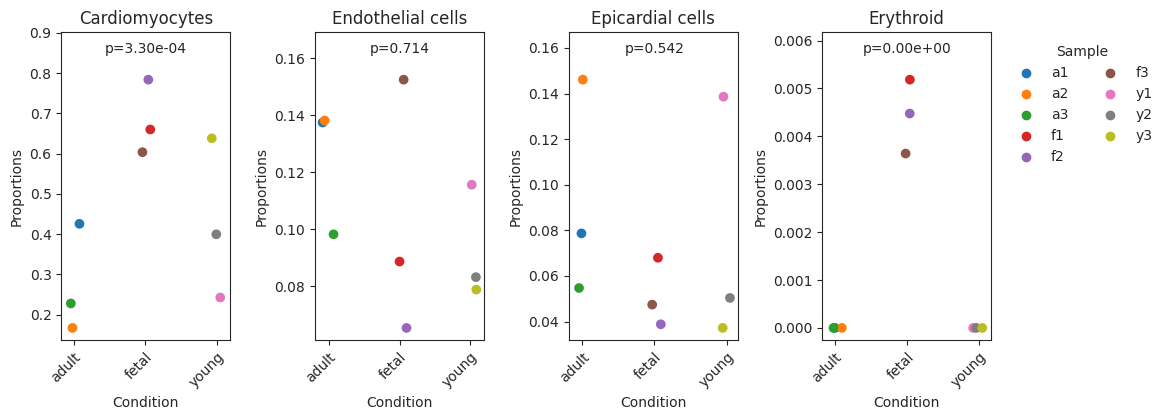

In [11]:
# original samples
scanpro_out.plot(n_columns=4, clusters=['Cardiomyocytes','Endothelial cells','Epicardial cells','Erythroid'],
                 save=f'{FIG_PATH}/heart_stripplot.pdf')

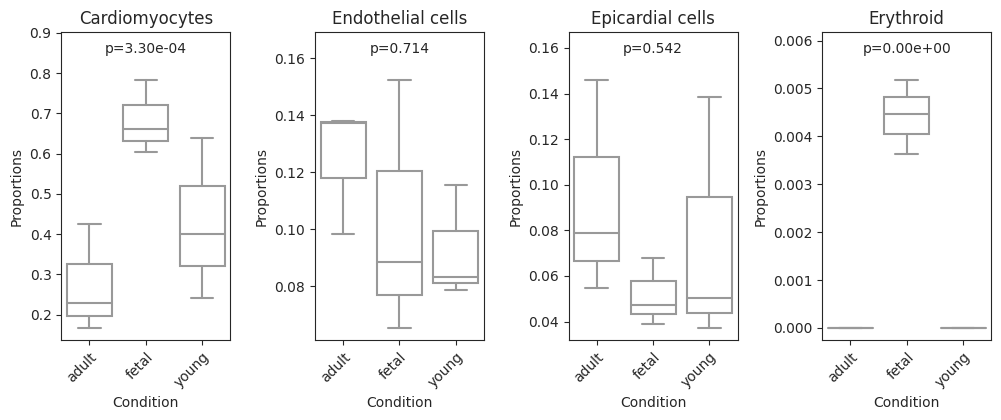

In [12]:
scanpro_out.plot(kind='boxplot', n_columns=4, clusters=['Cardiomyocytes','Endothelial cells',
                                                        'Epicardial cells','Erythroid'],
                 save=f'{FIG_PATH}/heart_boxplot.pdf')

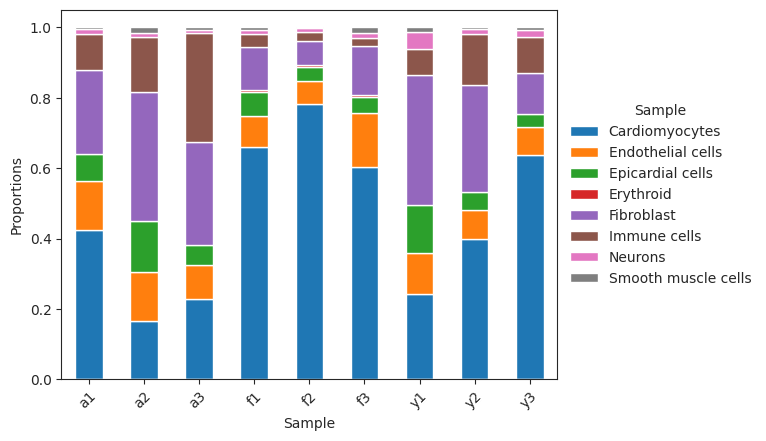

In [13]:
scanpro_out.plot_samples(save=f"{FIG_PATH}/heart_sample_barplot.pdf")

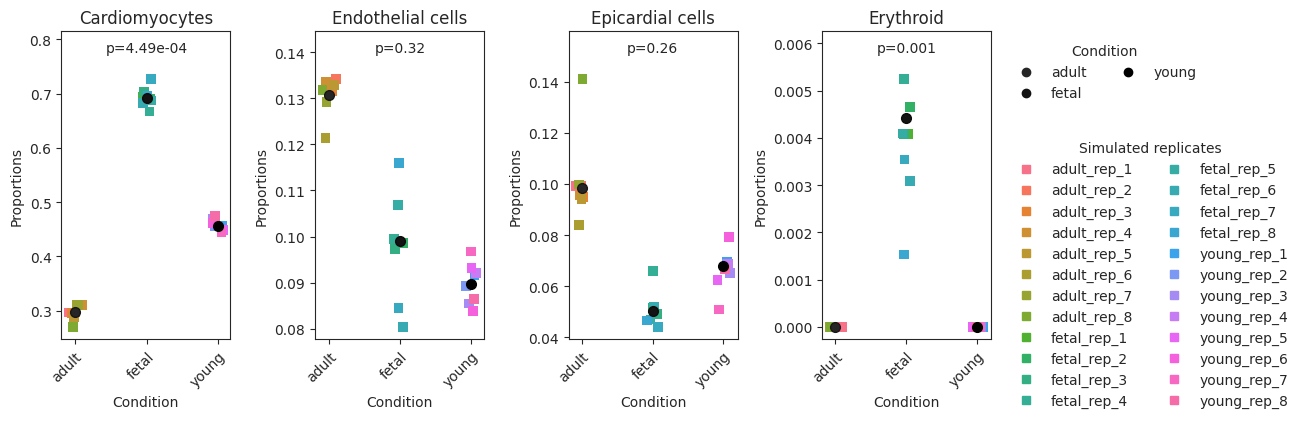

In [14]:
# Simulated replicates
scanpro_out_norep.plot(n_columns=4, clusters=['Cardiomyocytes','Endothelial cells','Epicardial cells','Erythroid'],
                       save=f'{FIG_PATH}/heart_norep_stripplot.pdf')

---------------------

## Propeller

In [15]:
%%R -i heart -o propeller_results
library(speckle)

propeller_results = propeller(clusters = heart$Celltype, sample = heart$Sample, group = heart$Condition)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Performing logit transformation of proportions
group variable has > 2 levels, ANOVA will be performed


In [16]:
propeller_results

,BaselineProp,PropMean.adult,PropMean.fetal,PropMean.young,Fstatistic,P.Value,FDR
Erythroid,0.002272,-0.000000,0.004433,-0.000000,46.591998,5.825757e-21,4.660605e-20
Immune cells,0.076302,0.189588,0.027546,0.108751,11.575093,9.397256e-06,3.758902e-05
Cardiomyocytes,0.549464,0.273547,0.682410,0.426761,9.068229,1.152704e-04,3.073879e-04
Fibroblast,0.182102,0.298689,0.111342,0.261924,4.630794,9.747019e-03,1.949404e-02
Neurons,0.016143,0.011381,0.012643,0.026210,1.519245,2.188770e-01,3.502033e-01
Epicardial cells,0.064167,0.093158,0.051415,0.075410,0.909787,4.026099e-01,5.368133e-01
Smooth muscle cells,0.007942,0.009099,0.008102,0.008465,0.421692,6.559362e-01,7.117040e-01
Endothelial cells,0.101607,0.124538,0.102108,0.092478,0.340093,7.117040e-01,7.117040e-01


In [17]:
propeller_results.to_csv("results/heart_propeller_rep.tsv", sep="\t")

------------

## scCODA

### Data preperation

In [18]:
# With replicates
sccoda_data  = dat.from_pandas(heart_counts, covariate_columns=["Sample", "Condition", "Sex"])

# Without replicates
counts_merged = heart_counts.groupby("Condition").sum(numeric_only=True).reset_index()
sccoda_data_norep = dat.from_pandas(counts_merged, covariate_columns=["Condition"])

### With replicates

In [19]:
sccoda_model = mod.CompositionalAnalysis(sccoda_data, formula="Condition", reference_cell_type="automatic")
sccoda_results = sccoda_model.sample_hmc()

Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-07-04 11:24:23.553864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:24:23.555449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:24:23.567969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:24:23.569032: I tens

2023-07-04 11:24:24.597718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:24:24.638568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,9]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:24:24.978919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (207.450 sec)
Acceptance rate: 69.9%


In [20]:
sccoda_out = sccoda_results.credible_effects().to_frame(name="credible_effect")
sccoda_out.to_csv("results/heart_sccoda_rep.tsv", sep="\t")
sccoda_out

credible_effect
Covariate          Cell Type                           
Condition[T.fetal] Cardiomyocytes                  True
                   Endothelial cells              False
                   Epicardial cells               False
                   Erythroid                      False
                   Fibroblast                     False
                   Immune cells                   False
                   Neurons                        False
                   Smooth muscle cells            False
Condition[T.young] Cardiomyocytes                 False
                   Endothelial cells              False
                   Epicardial cells               False
                   Erythroid                      False
                   Fibroblast                     False
                   Immune cells                   False
                   Neurons                        False
                   Smooth muscle cells            False

### Without replicates

In [21]:
credeff_list = []
for _ in range(10):
    sccoda_model_norep = mod.CompositionalAnalysis(sccoda_data_norep, formula="Condition", reference_cell_type="automatic")
    sccoda_results_norep = sccoda_model_norep.sample_hmc()
    credeff_list.append(sccoda_results_norep.credible_effects())

Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:28:12.214012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:28:12.214185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:28:12.225746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:28:12.232133: I tens

2023-07-04 11:28:13.051689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:28:13.431889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:28:13.469650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (161.807 sec)
Acceptance rate: 53.9%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:31:14.070694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:31:14.101844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:31:14.350970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (141.430 sec)
Acceptance rate: 56.7%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:33:55.588624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:33:55.623965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:33:55.892020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (139.126 sec)
Acceptance rate: 44.0%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:36:35.050681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:36:35.087466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:36:35.348058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (133.069 sec)
Acceptance rate: 54.6%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:39:09.453938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:39:09.487122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:39:09.751745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (142.613 sec)
Acceptance rate: 57.8%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:41:51.740672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:41:51.772205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:41:52.026167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (133.765 sec)
Acceptance rate: 45.2%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:44:25.871383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:44:25.902733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:44:26.158544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (135.591 sec)
Acceptance rate: 53.2%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:47:02.968896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:47:02.999759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:47:03.257649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (135.872 sec)
Acceptance rate: 61.2%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:49:39.202716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:49:39.234325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:49:39.514267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (138.472 sec)
Acceptance rate: 37.2%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:52:19.063312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:52:19.096343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,3]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:52:19.378164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (138.705 sec)
Acceptance rate: 59.7%


In [22]:
# Collect credible effects
all_credeff = pd.concat(credeff_list)
pct_credeff = all_credeff.groupby(all_credeff.index.names).mean().to_frame("pct_credible_effect") * 100
pct_credeff

pct_credible_effect
Covariate          Cell Type                               
Condition[T.fetal] Cardiomyocytes                     100.0
                   Endothelial cells                    0.0
                   Epicardial cells                     0.0
                   Erythroid                            0.0
                   Fibroblast                           0.0
                   Immune cells                        60.0
                   Neurons                              0.0
                   Smooth muscle cells                  0.0
Condition[T.young] Cardiomyocytes                       0.0
                   Endothelial cells                    0.0
                   Epicardial cells                     0.0
                   Erythroid                            0.0
                   Fibroblast                           0.0
                   Immune cells                         0.0
                   Neurons                              0.0
                   Smooth muscle cells                  0.0

In [23]:
pct_credeff.to_csv("results/heart_sccoda_norep.tsv", sep="\t")